# How to run this notebook

1. Open 2 terminal tabs
2. From Terminal A, ssh into TACC the normal way - `ssh <username>@maverick2.tacc.utexas.edu`
3. From terminal B, ssh into TACC using the command - `ssh -L localhost:8888:127.0.0.1:8888 -L localhost:6006:localhost:6006 sbansal6@maverick2.tacc.utexas.edu`
4. From terminal A, request some resources on the GPU compute resource - `idev -p gtx -L work -m 180`
5. From terminal B, log into the compute resource provisioned using - `ssh -L localhost:8888:127.0.0.1:8888 -L localhost:6006:localhost:6006 <resource-name>`
6. From terminal B, run jupyter notebook - `jupyter lab --port 8888`
7. You should be able to open the jupyter notebook on the browser of your local computer.

# Assumptions

Following are the requirements:

Packages:

```
tensorflow                         2.1.0
tensorflow-estimator               2.1.0
tensorflow-gpu                     2.1.0
tensorflow-probability             0.9.0
tensorboard                        2.3.0
```

Modules:

`module load intel/17.0.4 python3/3.6.3 cuda/10.0 cudnn/7.6.2 nccl/2.4.7 tacc-singularity/3.4.2`

In addition to the above module you might need to add the following to your path:

`export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/opt/apps/cuda/10.1/targets/x86_64-linux/lib`


Because of some missing library issues in TACC and depending on the missing library you might need to find and add the library somewhere accessible and add that path to the `LD_LIBRARY_PATH`:

```
login1.maverick2(1006)$ find -O3 -L /opt/apps/ -name "*libcupti.so.10.1*"
/opt/apps/cuda/10.1/extras/CUPTI/lib64/libcupti.so.10.1
/opt/apps/cuda/10.1/extras/CUPTI/lib64/libcupti.so.10.1.208

login1.maverick2(1006)$ cp /opt/apps/cuda/10.1/extras/CUPTI/lib64/libcupti.so.10.1 $WORK/libcupti.so.10.1
login1.maverick2(1006)$ export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$WORK

```

# Experiment Details

There are 2 datasets - 

**A**: orig_faced + defaced volumes

**B**: refaced + defaced volumes


1. Randomly select 49 volumes from faced and refaced datasets. 
2. Generate a new dataset T_A, with these 49 faced + the corresponding 49 defaced, and T_B with the 49 defaced + 49 re-faced.
3. Put T_A and T_B aside
4. Run your 15-fold CV on the remainder:

**A_2 (N = 1000x2)**: 1000 faced + 1000 defaced

**B_2 (N = 1000x2)**: 1000 defaced + 1000 re-faced



## Step1 and Step2

In [6]:
!pip install random

ERROR: Could not find a version that satisfies the requirement random
ERROR: No matching distribution found for random


In [9]:
import os, sys
sys.path.append("..")
import numpy as np
from glob import glob
import pandas as pd
import random
from random import shuffle

# Define paths
ROOT_DIR = '/home/shank/HDDLinux/Stanford/data/mriqc-shared/conformed'

defaced_path = os.path.join(ROOT_DIR, 'deface/128')
refaced_path = os.path.join(ROOT_DIR, 'deface_refaced/128')

paths_d = []
paths_f = []
paths_r = []

for path in glob(defaced_path + "/*/*.nii*"):
    paths_d.append(path)
    
for path in glob(refaced_path + "/*/*.nii*"):
    paths_r.append(path)
    
# for path in glob(face_path + "/*/*.nii*"):
#     DS = path.split('/')[-2]
#     paths_f.append(path)
    

def generate_datasets(fpaths, dpaths, size, typ ='faced'):
    
    if typ not in ['faced', 'refaced']:
        print("Incorrect value for t. Choose from [faced, refaced]")
        return
    
    random.shuffle(fpaths)
    test_f = fpaths[:size]
    main_f = fpaths[size:]

    test_d = []
    for t in test_f:
        if typ == 'faced':
            test_d.append(t.replace('face', 'face_defaced'))
        
        if typ == 'refaced':
            DS = t.split('/')[-2]
            sub = t.split('/')[-1].replace('_defaced_refaced', '').split('.nii.gz')[0]
            search_pattern = os.path.join(DS, sub)
            
            # match pattern from defaced dataset
            for _d in dpaths:
                if search_pattern in _d:
                    test_d.append(_d)
                

    test = test_f + test_d
    labels_test = [1]*len(test_f) + [0]*len(test_d)
    
    # remove T_A_D from defaced volume set
    main_d = list(set(dpaths) - set(test_d))
    
    labels_main = [1]*len(main_f) + [0]*len(main_d)
    main = main_f + main_d
    
    return main, labels_main, test, labels_test

# A_2, L_A_2, T_A, L_T_A = generate_datasets(paths_f, paths_d, 49, typ='faced')
B_2, L_B_2, T_B, L_T_B = generate_datasets(paths_r, paths_d, 49, typ='refaced')

# print(len(A_2), len(T_A))
print(len(B_2), len(T_B))


1911 49


## Generate n-fold CV Datasets

In [10]:
from operator import itemgetter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from random import shuffle
import os

def generate_CSV(paths, labels, save_path, test_paths=None, test_labels=None, n=15, mode='CV'):
    
    os.makedirs(save_path, exist_ok=True)
    
    df = pd.DataFrame()
    df["X"] = paths
    df["Y"] = labels
    df.to_csv(os.path.join(save_path, "all.csv"))
    
    if mode == 'CV':
        SPLITS = n
        skf = StratifiedKFold(n_splits=SPLITS)
        fold_no = 1

        for train_index, test_index in skf.split(paths, labels):
            out_path = os.path.join(save_path, "train_test_fold_{}/csv/".format(fold_no))

            if not os.path.exists(out_path):
                os.makedirs(out_path)

            image_train, image_test = (
                itemgetter(*train_index)(paths),
                itemgetter(*test_index)(paths),
            )

            label_train, label_test = (
                itemgetter(*train_index)(labels),
                itemgetter(*test_index)(labels),
            )

            train_data = {"X": image_train , "Y": label_train}
            df_train = pd.DataFrame(train_data)
            df_train.to_csv(os.path.join(out_path, "training.csv"), index=False)

            validation_data = {"X": image_test, "Y": label_test}
            df_validation = pd.DataFrame(validation_data)
            df_validation.to_csv(os.path.join(out_path, "validation.csv"), index=False)

            fold_no += 1
    else:
        train_data = {"X": paths , "Y": labels}
        df_train = pd.DataFrame(train_data)
        df_train.to_csv(os.path.join(save_path, "training.csv"), index=False)
        
        test_data = {"X": test_paths , "Y": test_labels}
        df_test = pd.DataFrame(test_data)
        df_test.to_csv(os.path.join(save_path, "testing.csv"), index=False)
        
## CROSS VALIDATION
# generate_CSV(A_2, L_A_2, "experiments/experiment_A/csv_F15")
# generate_CSV(B_2, L_B_2, "/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced/csv_F15")


## DEFINE A ROOT DIR where all the data will be stored <<<<<
ROOT_DIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments' 

## FULL DATASET
# generate_CSV(A_2,
#              L_A_2,
#              os.path.join(ROOT_DIR, 'experiment_A/128/csv_full'),
#              test_paths=T_A,
#              test_labels=L_T_A,
#              mode='full')

generate_CSV(B_2,
             L_B_2,
             os.path.join(ROOT_DIR, 'experiment_defaced/128/csv_full'),
             test_paths=T_B,
             test_labels=L_T_B,
             mode='full')


# Generate tfrecords for n-fold CV datasets

In [11]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd


def generate_tfrecords(csv_path, records_save_path, mode='CV'):
    
    os.makedirs(records_save_path, exist_ok=True)

    train_csv_path = os.path.join(csv_path, "training.csv")
    

    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    train_D = list(zip(train_paths, train_labels))
    
    random.shuffle(train_D)

    train_write_path = os.path.join(records_save_path, 'data-train_shard-{shard:03d}.tfrec')
    
    nobrainer.tfrecord.write(
        features_labels=train_D,
        filename_template=train_write_path,
        examples_per_shard=3)
    
    if mode =='CV':
        valid_csv_path = os.path.join(csv_path, "validation.csv")
        valid_paths = pd.read_csv(valid_csv_path)["X"].values
        valid_labels = pd.read_csv(valid_csv_path)["Y"].values
        valid_D = list(zip(valid_paths, valid_labels))
        random.shuffle(valid_D)
        valid_write_path = os.path.join(records_save_path, 'data-valid_shard-{shard:03d}.tfrec')

        nobrainer.tfrecord.write(
            features_labels=valid_D,
            filename_template=valid_write_path,
            examples_per_shard=1)
    
    if mode == 'test':
        test_csv_path = os.path.join(csv_path, "testing.csv")
        test_paths = pd.read_csv(test_csv_path)["X"].values
        test_labels = pd.read_csv(test_csv_path)["Y"].values
        test_D = list(zip(test_paths, test_labels))
        random.shuffle(test_D)
        test_write_path = os.path.join(records_save_path, 'data-test_shard-{shard:03d}.tfrec')

        nobrainer.tfrecord.write(
            features_labels=test_D,
            filename_template=test_write_path,
            examples_per_shard=1)

# Cross-Validation 
# SPLITS = 15
# for fold in range(1, SPLITS+1):
#     print("FOLD: ", fold)
#     csv_path = "/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced/csv_F15/train_test_fold_{}/csv/".format(fold)
#     tf_records_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced/tfrecords_F15/tfrecords_fold_{}/".format(fold)
#     generate_tfrecords(csv_path, tf_records_dir)

ROOT_DIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments' 

# Test (full dataset)
# experiment_A
# csv_path = os.path.join(ROOT_DIR, "experiment_A/128/csv_full")
# tf_records_dir = os.path.join(ROOT_DIR, "experiment_A/128/tfrecords_full")
# generate_tfrecords(csv_path, tf_records_dir, mode='test')

# experiment_B
csv_path = os.path.join(ROOT_DIR, "experiment_defaced/128/csv_full")
tf_records_dir = os.path.join(ROOT_DIR, "experiment_defaced/128/tfrecords_full")
generate_tfrecords(csv_path, tf_records_dir, mode='test')

## Main held-out Test Dataset

637/637 [==============================] - 57s 90ms/step


KeyboardInterrupt: 

In [14]:
!pip install sklearn

  Using cached scikit_learn-0.24.1-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0.0-py3-none-any.whl (302 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=afd7f3bdfc35c268bd5c0e22536e5e72abf0aa974de41bec9d39005eb850c6a4
  Stored in directory: /home/shank/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


## Initialize dataset model

In [12]:
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks
import sys, os
sys.path.append('../defacing')
from preprocessing.augmentation import VolumeAugmentations, SliceAugmentations
from helpers.utils import load_vol
import tensorflow_probability as tfp
import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
DISTRIBUTION = load_vol('../defacing/helpers/distribution.nii.gz')[0]
DISTRIBUTION /= DISTRIBUTION.sum()
COM = np.unravel_index(int(np.sum(DISTRIBUTION.ravel()*np.arange(len(DISTRIBUTION.ravel())))/np.sum(DISTRIBUTION.ravel())), DISTRIBUTION.shape)


# sampling from augmented distribution is same as augmenting the sampled points
# augmenting distribution at every iteration is expensive, so this way
sampler = lambda n_slices, distribution = DISTRIBUTION, threshold = 0.1: np.array([ np.unravel_index(
          np.random.choice(np.arange(np.prod(distribution.shape)),
                                     p = distribution.ravel()),
          distribution.shape) + (+1 if np.random.randn() > 0.5 else -1)*np.random.randint(0, 
                                        int(distribution.shape[0]*threshold) + 1, 3) for _ in range(n_slices)]) 


three_d_augmentations = {'rotation': 0.5,
                         'translation': 0.5,
                         'noop': 0.3
                        }

augmentvolume = VolumeAugmentations(DISTRIBUTION, three_d_augmentations)

two_d_augmentations = {'rotation': 0.5,
                       'fliplr': 0.5,
                       'flipud': 0.5,
                       'zoom': 0.5,
                       'noop': 0.3
                      }

# augmentslice = VolumeAugmentations(DISTRIBUTION, two_d_augmentations)


def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n_slices = 24,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    augment=False,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
    mode='train',
):

    """ Returns tf.data.Dataset after preprocessing from
    tfrecords for training and validation

    Parameters
    ----------
    file_pattern:

    n_classes:
    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )

    # if augment:
    #     ds = ds.map(
    #         lambda x, y: tf.cond(
    #             tf.random.uniform((1,)) > 0.5,
    #             true_fn=lambda: apply_augmentations(x, y),
    #             false_fn=lambda: (x, y),
    #         ),
    #         num_parallel_calls=num_parallel_calls,
    #     )

    def _ss(x, y):
        if augment:
            if three_d_augmentations['noop'] < 1:
                x, y = augmentvolume(x,y)
        x, y = structural_slice(x, y, 
                                plane, 
                                n_slices, 
                                augment, 
                                augmentvolume.distribution)
        return (x, y)
    
    
    ds = ds.map(_ss, num_parallel_calls)
    
    ds = ds.prefetch(buffer_size=batch_size)

    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=True)
        
    if mode == 'train':
        if shuffle_buffer_size:
            ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat the dataset n_epochs times
        ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, 
                plane, 
                n_slices = 4, 
                augment = False, 
                distribution = DISTRIBUTION):

    """ Transpose dataset based on the plane

    Parameters
    ----------
    x:

    y:

    plane:
    
    n:

    augment:
    """

    threshold = 0.1 if augment else 0.0 
    options = ["axial", "coronal", "sagittal", "combined"]
    shape = np.array(x.shape)

    if isinstance(plane, str) and plane in options:
        idxs = sampler(n_slices, 
                        distribution, 
                        threshold)

        if plane == "axial":
            idx = np.random.randint(shape[0]**0.5)
            midx = idxs[:, 0]
            x = x

        if plane == "coronal":
            idx = np.random.randint(shape[1]**0.5)
            midx = idxs[:, 1]
            x = tf.transpose(x, perm=[1, 2, 0])


        if plane == "sagittal":
            idx = np.random.randint(shape[2]**0.5)
            midx = idxs[:, 2]
            x = tf.transpose(x, perm=[2, 0, 1])


        if plane == "combined":
            temp = {}
            for op in options[:-1]:
                temp[op] = structural_slice(x, y, 
                                            op, 
                                            n_slices, 
                                            augment, 
                                            distribution)[0]
            x = temp

        if not plane == "combined":
            x = tf.squeeze(tf.gather_nd(x, midx.reshape(n_slices, 1, 1)), axis=1)
            x = tf.math.reduce_mean(x, axis=0)
            x = tf.expand_dims(x, axis=-1)
            
            if augment:
                x = two_d_augmentations(x)
                
            x = tf.convert_to_tensor(x)
        return x, y
    else:
        raise ValueError("expected plane to be one of ['axial', 'coronal', 'sagittal']")


# if __name__ == "__main__":
#     ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_A/tfrecords_F15'
#     n_classes = 2
#     global_batch_size = 8
#     volume_shape = (64, 64, 64)
#     ds = get_dataset(
#         os.path.join(ROOTDIR, "tfrecords_fold_1/data-train_*"),
#         n_classes=n_classes,
#         batch_size=global_batch_size,
#         volume_shape=volume_shape,
#         plane="sagittal",
#         augment = False,
#         shuffle_buffer_size=3,
#     )

#     import matplotlib
#     matplotlib.use('Agg')
#     import matplotlib.pyplot as plt

#     print(ds)


## Initialize model

In [15]:
# Std packages
import sys, os
import glob
import math

sys.path.append("../defacing")

# Custom packages
from models import modelN
# from dataloaders.dataset import get_dataset

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses


def scheduler(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))


def train(
    csv_path,
    model_save_path,
    tfrecords_path,
    volume_shape=(64, 64, 64),
    image_size=(64, 64),
    dropout=0.2,
    batch_size=16,
    n_classes=2,
    n_epochs=15,
    percent=100,
    mode='CV',
):
    
    
    train_csv_path = os.path.join(csv_path, "training.csv")
    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    
    if mode == 'CV':
        valid_csv_path = os.path.join(csv_path, "validation.csv")
        valid_paths = pd.read_csv(valid_csv_path)["X"].values
        valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_labels),
                                                train_labels)
    weights = dict(enumerate(weights))
    
    print(weights)
    
    planes = ["axial", "coronal", "sagittal", "combined"]
    

    global_batch_size = batch_size
    
    os.makedirs(model_save_path, exist_ok=True)
    cp_save_path = os.path.join(model_save_path, "weights")

    logdir_path = os.path.join(model_save_path, "tb_logs")
    if not os.path.exists(logdir_path):
        os.makedirs(logdir_path)

    for plane in planes:

        logdir = os.path.join(logdir_path, plane)
        os.makedirs(logdir, exist_ok=True)

        tbCallback = TensorBoard(
            log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True,
        )

        os.makedirs(os.path.join(cp_save_path, plane), exist_ok=True)

        model_checkpoint = ModelCheckpoint(
            os.path.join(cp_save_path, plane, "best-wts.h5"),
            monitor="val_loss",
            save_weights_only=True,
            mode="min",
        )

#         with strategy.scope():

        if not plane == "combined": 
            lr = 1e-3
            model = modelN.Submodel(
                input_shape=image_size,
                dropout=dropout,
                name=plane,
                include_top=True,
                weights=None,
            )
        else:
            lr = 5e-4
            model = modelN.CombinedClassifier(
                input_shape=image_size,
                dropout=dropout,
                trainable=True,
                wts_root=cp_save_path,
            )

        print("Submodel: ", plane)
#         print(model.summary())

        METRICS = [
            metrics.TruePositives(name="tp"),
            metrics.FalsePositives(name="fp"),
            metrics.TrueNegatives(name="tn"),
            metrics.FalseNegatives(name="fn"),
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
        ]

        model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer=Adam(learning_rate=lr),
            metrics=METRICS,
        )

        print("GLOBAL BATCH SIZE: ", global_batch_size)

        dataset_train = get_dataset(
            file_pattern=os.path.join(tfrecords_path, 'data-train_*'),
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )
        
        steps_per_epoch = math.ceil(len(train_paths)/batch_size)
        print(steps_per_epoch)
        lrcallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        if mode == 'CV':
            dataset_valid = get_dataset(
                file_pattern=os.path.join(tfrecords_path, "data-valid_*"),
                n_classes=n_classes,
                batch_size=global_batch_size,
                volume_shape=volume_shape,
                plane=plane,
                shuffle_buffer_size=global_batch_size,
            )
            
            validation_steps = math.ceil(len(valid_paths)/batch_size)
            
            model.fit(
                dataset_train,
                epochs=n_epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=dataset_valid,
                validation_steps=validation_steps,
                callbacks=[tbCallback, model_checkpoint],
                class_weight = weights,
            )
        else:
            model.fit(
                dataset_train,
                epochs=n_epochs,
                steps_per_epoch=steps_per_epoch,
                callbacks=[tbCallback, model_checkpoint],
                class_weight = weights,
            )

        del model
        
        K.clear_session()

## n-fold CV

In [9]:
ROOT_DIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced'

for fold in range(15, 16):
    print("FOLD {}".format(fold))
    csv_path = os.path.join(ROOT_DIR, "csv_F15/train_test_fold_{}/csv".format(fold))
    model_save_path = os.path.join(ROOT_DIR, "model_save_dir_F15/train_test_fold_{}".format(fold))
    tfrecords_path = os.path.join(ROOT_DIR, 'tfrecords_F15/tfrecords_fold_{}'.format(fold))
    
    train(
        csv_path,
        model_save_path,
        tfrecords_path,
        volume_shape=(128, 128, 128),
        image_size=(128, 128),
        mode='CV'
    )

FOLD 15
{0: 0.9748633879781421, 1: 1.0264672036823936}
Submodel:  axial
GLOBAL BATCH SIZE:  16
112
Train for 112 steps, validate for 8 steps
Epoch 1/15
112/112 [==============================] - 16s 145ms/step - loss: 0.3070 - tp: 809.0000 - fp: 62.0000 - tn: 857.0000 - fn: 64.0000 - accuracy: 0.9297 - precision: 0.9288 - recall: 0.9267 - auc: 0.9701 - val_loss: 1.7782 - val_tp: 63.0000 - val_fp: 65.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4922 - val_precision: 0.4922 - val_recall: 1.0000 - val_auc: 0.5415
Epoch 2/15
112/112 [==============================] - 11s 95ms/step - loss: 0.1116 - tp: 835.0000 - fp: 33.0000 - tn: 886.0000 - fn: 38.0000 - accuracy: 0.9604 - precision: 0.9620 - recall: 0.9565 - auc: 0.9929 - val_loss: 2.6909 - val_tp: 63.0000 - val_fp: 65.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4922 - val_precision: 0.4922 - val_recall: 1.0000 - val_auc: 0.6788
Epoch 3/15
112/112 [==============================] - 11s 98ms/step - 

Epoch 6/15
112/112 [==============================] - 13s 121ms/step - loss: 0.0705 - tp: 854.0000 - fp: 26.0000 - tn: 878.0000 - fn: 34.0000 - accuracy: 0.9665 - precision: 0.9705 - recall: 0.9617 - auc: 0.9969 - val_loss: 0.1134 - val_tp: 65.0000 - val_fp: 5.0000 - val_tn: 57.0000 - val_fn: 1.0000 - val_accuracy: 0.9531 - val_precision: 0.9286 - val_recall: 0.9848 - val_auc: 0.9934
Epoch 7/15
112/112 [==============================] - 14s 122ms/step - loss: 0.0717 - tp: 834.0000 - fp: 33.0000 - tn: 892.0000 - fn: 33.0000 - accuracy: 0.9632 - precision: 0.9619 - recall: 0.9619 - auc: 0.9965 - val_loss: 0.2572 - val_tp: 53.0000 - val_fp: 0.0000e+00 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8689 - val_auc: 0.9775
Epoch 8/15
112/112 [==============================] - 14s 123ms/step - loss: 0.0666 - tp: 829.0000 - fp: 24.0000 - tn: 904.0000 - fn: 35.0000 - accuracy: 0.9671 - precision: 0.9719 - recall: 0.9595 - auc: 0.9971 - val_loss

Epoch 12/15
112/112 [==============================] - 15s 132ms/step - loss: 0.0686 - tp: 817.0000 - fp: 0.0000e+00 - tn: 919.0000 - fn: 56.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.9359 - auc: 0.9948 - val_loss: 0.0863 - val_tp: 57.0000 - val_fp: 0.0000e+00 - val_tn: 66.0000 - val_fn: 5.0000 - val_accuracy: 0.9609 - val_precision: 1.0000 - val_recall: 0.9194 - val_auc: 0.9932
Epoch 13/15
112/112 [==============================] - 14s 128ms/step - loss: 0.0638 - tp: 826.0000 - fp: 1.0000 - tn: 914.0000 - fn: 51.0000 - accuracy: 0.9710 - precision: 0.9988 - recall: 0.9418 - auc: 0.9957 - val_loss: 0.3512 - val_tp: 52.0000 - val_fp: 0.0000e+00 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.9219 - val_precision: 1.0000 - val_recall: 0.8387 - val_auc: 0.9831
Epoch 14/15
112/112 [==============================] - 15s 133ms/step - loss: 0.0899 - tp: 801.0000 - fp: 1.0000 - tn: 926.0000 - fn: 64.0000 - accuracy: 0.9637 - precision: 0.9988 - recall: 0.9260 - auc: 0.9938 -

GLOBAL BATCH SIZE:  16
112
Train for 112 steps, validate for 8 steps
Epoch 1/15
112/112 [==============================] - 27s 241ms/step - loss: 0.7811 - tp: 767.0000 - fp: 110.0000 - tn: 813.0000 - fn: 102.0000 - accuracy: 0.8817 - precision: 0.8746 - recall: 0.8826 - auc: 0.9349 - val_loss: 0.6790 - val_tp: 63.0000 - val_fp: 65.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4922 - val_precision: 0.4922 - val_recall: 1.0000 - val_auc: 0.9336
Epoch 2/15
112/112 [==============================] - 19s 166ms/step - loss: 0.0888 - tp: 844.0000 - fp: 31.0000 - tn: 879.0000 - fn: 38.0000 - accuracy: 0.9615 - precision: 0.9646 - recall: 0.9569 - auc: 0.9948 - val_loss: 0.9311 - val_tp: 59.0000 - val_fp: 62.0000 - val_tn: 7.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5156 - val_precision: 0.4876 - val_recall: 1.0000 - val_auc: 0.9263
Epoch 3/15
112/112 [==============================] - 18s 164ms/step - loss: 0.0703 - tp: 846.0000 - fp: 27.0000 - tn: 896.0000 - fn: 23.0000 -

## Tensorboard graph visualization

NOTE: For this to work, you need to have the 6006 port binded from the localhost as shown in the first block

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_A/model_save_dir_F15 

## Train a model on full dataset

In [13]:
import glob
ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced/128'

csv_path = os.path.join(ROOTDIR, "csv_full")
model_save_path = os.path.join(ROOTDIR, "model_save_dir_full")
tfrecords_path = os.path.join(ROOTDIR, 'tfrecords_full')


train(
    csv_path,
    model_save_path,
    tfrecords_path,
    volume_shape=(128, 128, 128),
    image_size=(128, 128),
    mode='full'
)

{0: 0.975, 1: 1.0263157894736843}
Submodel:  axial
GLOBAL BATCH SIZE:  16
120
Train for 120 steps
Epoch 1/15
120/120 [==============================] - 14s 117ms/step - loss: 0.3437 - tp: 867.0000 - fp: 83.0000 - tn: 901.0000 - fn: 69.0000 - accuracy: 0.9208 - precision: 0.9126 - recall: 0.9263 - auc: 0.9651
Epoch 2/15
120/120 [==============================] - 9s 73ms/step - loss: 0.1154 - tp: 903.0000 - fp: 49.0000 - tn: 936.0000 - fn: 32.0000 - accuracy: 0.9578 - precision: 0.9485 - recall: 0.9658 - auc: 0.9920
Epoch 3/15
120/120 [==============================] - 9s 72ms/step - loss: 0.1313 - tp: 900.0000 - fp: 45.0000 - tn: 938.0000 - fn: 37.0000 - accuracy: 0.9573 - precision: 0.9524 - recall: 0.9605 - auc: 0.9920
Epoch 4/15
120/120 [==============================] - 9s 74ms/step - loss: 0.0700 - tp: 898.0000 - fp: 29.0000 - tn: 959.0000 - fn: 34.0000 - accuracy: 0.9672 - precision: 0.9687 - recall: 0.9635 - auc: 0.9966
Epoch 5/15
120/120 [==============================] - 9s 74m

GLOBAL BATCH SIZE:  16
120
Train for 120 steps
Epoch 1/15
120/120 [==============================] - 23s 190ms/step - loss: 0.9880 - tp: 815.0000 - fp: 133.0000 - tn: 849.0000 - fn: 123.0000 - accuracy: 0.8667 - precision: 0.8597 - recall: 0.8689 - auc: 0.9184
Epoch 2/15
120/120 [==============================] - 15s 128ms/step - loss: 0.1175 - tp: 889.0000 - fp: 43.0000 - tn: 944.0000 - fn: 44.0000 - accuracy: 0.9547 - precision: 0.9539 - recall: 0.9528 - auc: 0.9926
Epoch 3/15
120/120 [==============================] - 15s 126ms/step - loss: 0.0670 - tp: 899.0000 - fp: 28.0000 - tn: 962.0000 - fn: 31.0000 - accuracy: 0.9693 - precision: 0.9698 - recall: 0.9667 - auc: 0.9970
Epoch 4/15
120/120 [==============================] - 15s 125ms/step - loss: 0.0750 - tp: 907.0000 - fp: 34.0000 - tn: 943.0000 - fn: 36.0000 - accuracy: 0.9635 - precision: 0.9639 - recall: 0.9618 - auc: 0.9965
Epoch 5/15
120/120 [==============================] - 15s 126ms/step - loss: 0.0472 - tp: 902.0000 - fp

In [14]:
import sys, os
sys.path.append('../defacing')
from models.modelN import CombinedClassifier

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses

ROOTDIR_B = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced/128'
ROOTDIR_A = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_A/128'

csv_path = os.path.join(ROOTDIR, "csv_full")
model_save_path = os.path.join(ROOTDIR_B, "model_save_dir_full")
tfrecords_path = os.path.join(ROOTDIR_A, 'tfrecords_full')
weights_path = os.path.join(model_save_path, 'weights/combined/best-wts.h5')


model = CombinedClassifier(
    input_shape=(128, 128), dropout=0.4, wts_root=None, trainable=True
)
model.load_weights(os.path.abspath(weights_path))


dataset_test = get_dataset(
    file_pattern=os.path.join(tfrecords_path, "data-test_*"),
    n_classes=2,
    n_slices = 24,
    batch_size=16,
    volume_shape=(128, 128, 128),
    plane='combined',
    mode='test'
)

METRICS = [
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
        ]

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(learning_rate=1e-3),
    metrics=METRICS,
)

    
results = model.evaluate(dataset_test)
predictions = (model.predict(dataset_test) > 0.5).astype(int)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
axial (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sagittal (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
coronal (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          axial[0][0]                      
____________________________________________________________________________________________

      6/Unknown - 3s 521ms/step - loss: 0.4054 - accuracy: 0.8750 - precision: 1.0000 - recall: 0.7500 - auc: 0.9792

In [ ]:
print(dataset_test)
import matplotlib.pyplot as plt
corr_pred_map = {}

# for x, y in dataset_test.enumerate():
for x, y in dataset_test.as_numpy_iterator():
    
    batch_predictions = (model.predict(x) > 0.5).astype(int)
    all_imgs = []
    for i in range(len(batch_predictions)):
        if batch_predictions.flatten()[i] != y.flatten()[i].astype(int):
            print("Predicted: ",batch_predictions.flatten()[i], "Actual: ", y.flatten()[i].astype(int))
            
            fig = plt.figure(figsize=(25, 8))
            rows, cols = 3, 16
            use = x['axial']
            for i in range(1, cols*rows + 1):
                if i/cols == 1:
                    use = x['coronal']
                if i/cols == 2:
                    use = x['sagittal']
                    
                fig.add_subplot(rows, cols, i)
                
                plt.imshow(use[(i-1)%cols,:,:, 0])


            plt.show()

In [13]:
import pandas as pd
import glob, os

ixi_root_dir = '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128'
ixi_deface_root_dir = '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/deface/128'
cpaths = glob.glob(os.path.join(ixi_root_dir, '*.nii*'))
cpaths_deface = glob.glob(os.path.join(ixi_deface_root_dir, '*.nii*'))

# true_labels = pd.read_csv(os.path.join(test_root_dir, 'test1_images_gt.csv'))
# tl_dict = {}
# for i, row in enumerate(true_labels.values):
    
#     dataset, volume, label = row
#     l = 0 if 'deface' in label else 1
#     tl_dict[str(dataset) + '/' + str(volume)] = l
    
test_df_dict = {}
X, Y = [], []

for path in cpaths:
#     print(path)
    name = '/'.join(path.rsplit('/', 2)[-2:])
    X.append(path)
    Y.append(1)
    
for path in cpaths_deface:
#     print(path)
    name = '/'.join(path.rsplit('/', 2)[-2:])
    X.append(path)
    Y.append(0)


# print(X, Y)
import random

zipped = list(zip(X, Y))
random.shuffle(zipped)
_X, _Y = zip(*zipped)

test_df_dict['X'] = _X
test_df_dict['Y'] = _Y

df_test = pd.DataFrame(data=test_df_dict)
df_test.to_csv(os.path.join("/work/06850/sbansal6/maverick2/mriqc-shared/test_ixi/csv/testing.csv"), index=False)

/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI022-Guys-0701-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI199-Guys-0802-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI337-IOP-0929-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI067-HH-1356-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI422-Guys-1071-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI164-Guys-0844-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI136-HH-1452-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI043-Guys-0714-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI385-HH-2078-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/IXI592-Guys-1085-T1.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/ixi/face/128/

## Convert test data to tfrecords

In [14]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

test_root_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/test_ixi"
csv_path = os.path.join(test_root_dir, "csv")
tf_records_dir = os.path.join(test_root_dir, "tfrecords")

os.makedirs(tf_records_dir, exist_ok=True)

test_csv_path = os.path.join(csv_path, "testing.csv")
test_paths = pd.read_csv(test_csv_path)["X"].values
test_labels = pd.read_csv(test_csv_path)["Y"].values
test_D = list(zip(test_paths, test_labels))
test_write_path = os.path.join(tf_records_dir, 'data-test_shard-{shard:03d}.tfrec')

nobrainer.tfrecord.write(
    features_labels=test_D,
    filename_template=test_write_path,
    examples_per_shard=3)

388/388 [==============================] - 26s 68ms/step


In [10]:
import sys, os
sys.path.append('../defacing')
from models.modelN import CombinedClassifier
import glob

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses

ROOTDIR_B = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_defaced/128'
ROOTDIR_A = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_A/128'
test_root_dir = '/work/06850/sbansal6/maverick2/mriqc-shared/test_ixi'

model_save_path = os.path.join(ROOTDIR_B, "model_save_dir_full")
tfrecords_path = os.path.join(test_root_dir, "tfrecords")
print("TFRECORDS: ", tfrecords_path)
weights_path = os.path.join(model_save_path, 'weights/combined/best-wts.h5')


model = CombinedClassifier(
    input_shape=(128, 128), dropout=0.4, wts_root=None, trainable=True
)
model.load_weights(os.path.abspath(weights_path))

print(os.path.join(tfrecords_path, "data-test_*"))
dataset_test = get_dataset(
    file_pattern=os.path.join(tfrecords_path, "data-test_*"),
    n_classes=2,
#     n_slices = 32,
    batch_size=24,
    volume_shape=(128, 128, 128),
    plane='combined',
    mode='test'
)

print(dataset_test)

METRICS = [metrics.TruePositives(name="tp"),
            metrics.FalsePositives(name="fp"),
            metrics.TrueNegatives(name="tn"),
            metrics.FalseNegatives(name="fn"),
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
]
model.trainable = False
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(learning_rate=1e-3),
    metrics=METRICS,
)

    
results = model.evaluate(dataset_test)
predictions = (model.predict(dataset_test) > 0.5).astype(int)

TFRECORDS:  /work/06850/sbansal6/maverick2/mriqc-shared/test_ixi/tfrecords
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
axial (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sagittal (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
coronal (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 128, 128, 8)  80          axial[0][0]                      
________________

<BatchDataset shapes: ({axial: (24, 128, 128, 1), coronal: (24, 128, 128, 1), sagittal: (24, 128, 128, 1)}, (24, 1)), types: ({axial: tf.float32, coronal: tf.float32, sagittal: tf.float32}, tf.float32)>
     48/Unknown - 9s 196ms/step - loss: 0.1303 - tp: 528.0000 - fp: 7.0000 - tn: 570.0000 - fn: 47.0000 - accuracy: 0.9531 - precision: 0.9869 - recall: 0.9183 - auc: 0.9953

Predicted:  0 Actual:  1


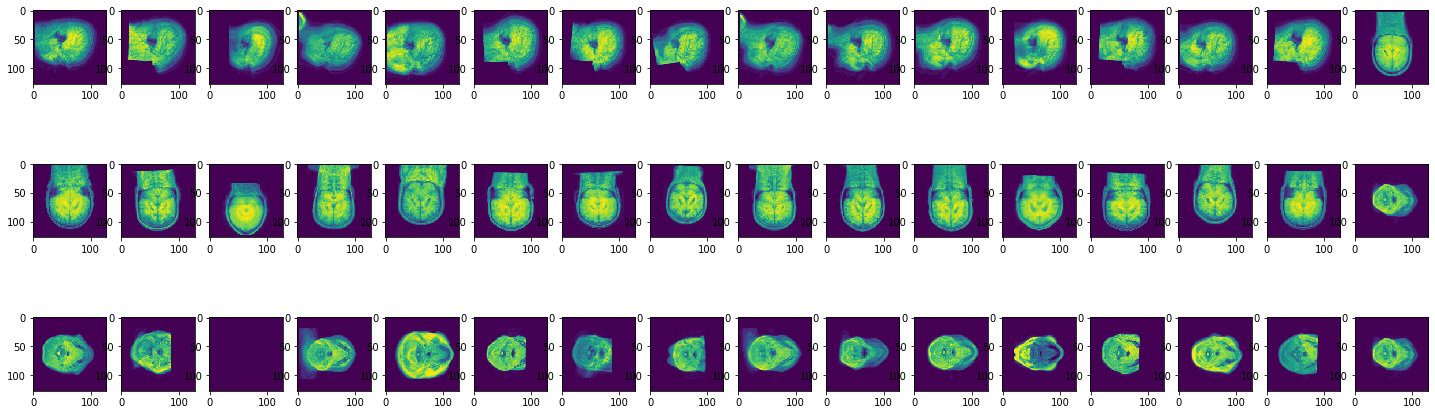

Predicted:  0 Actual:  1


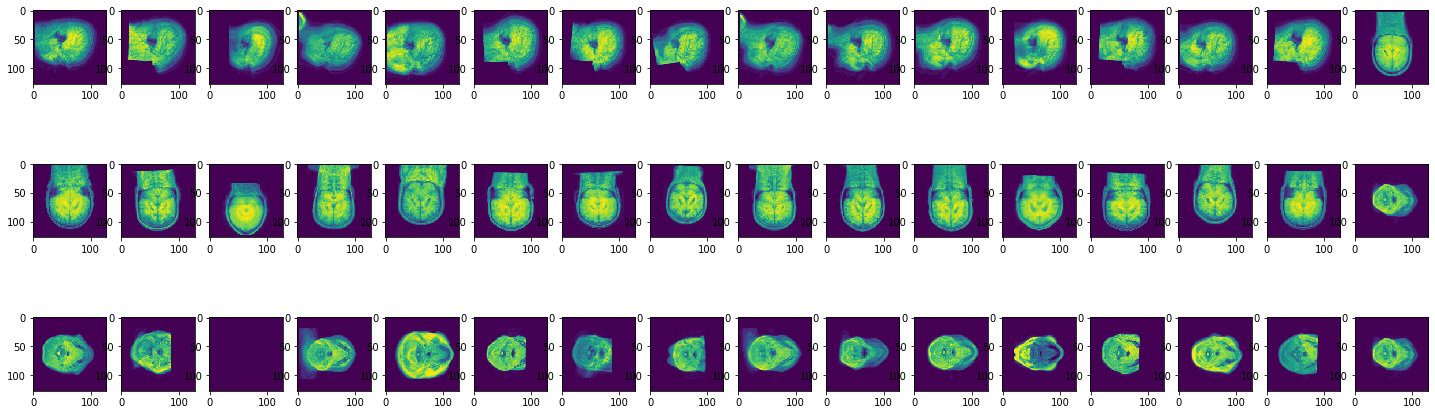

Predicted:  0 Actual:  1


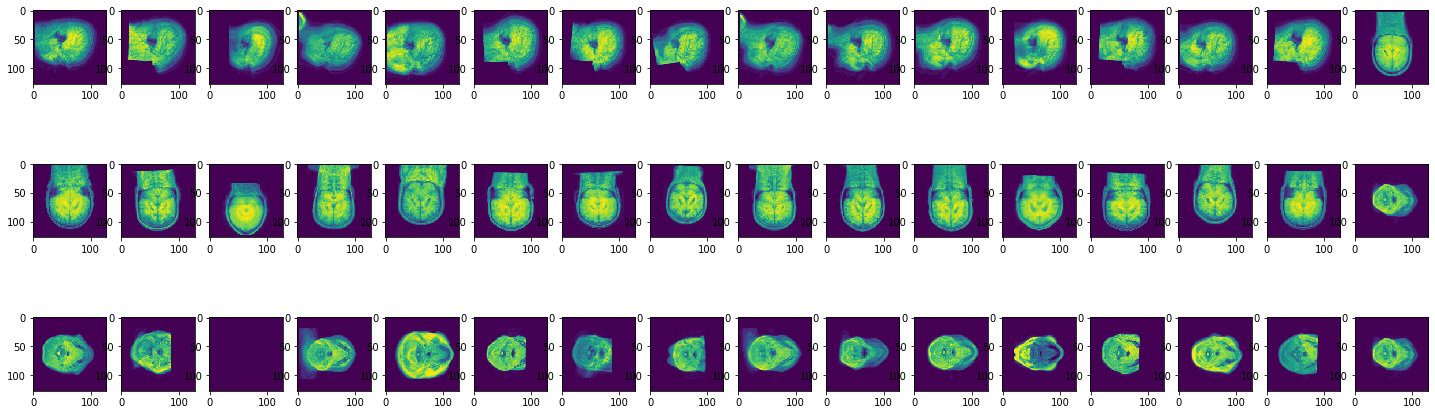

Predicted:  0 Actual:  1


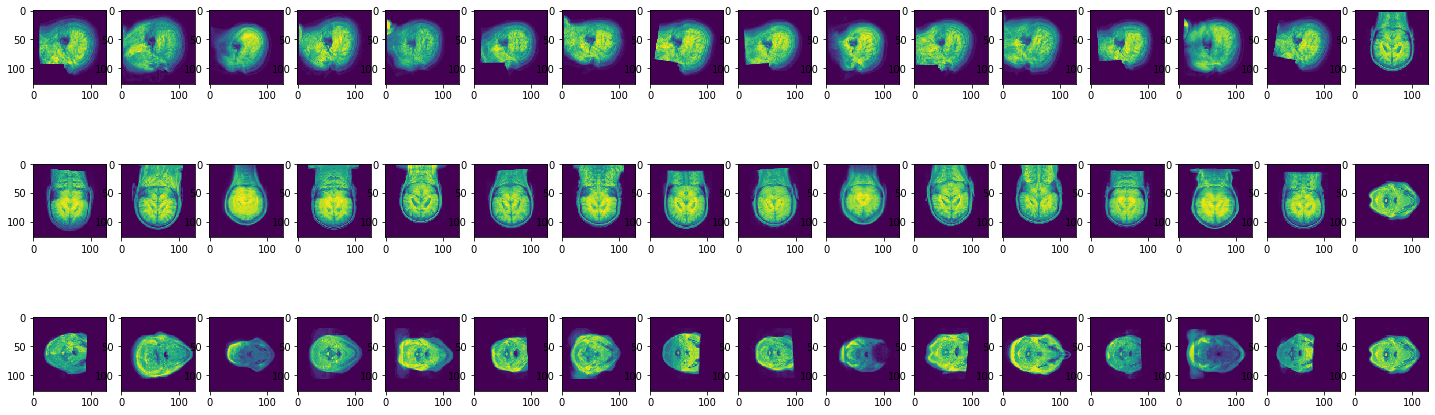

Predicted:  0 Actual:  1


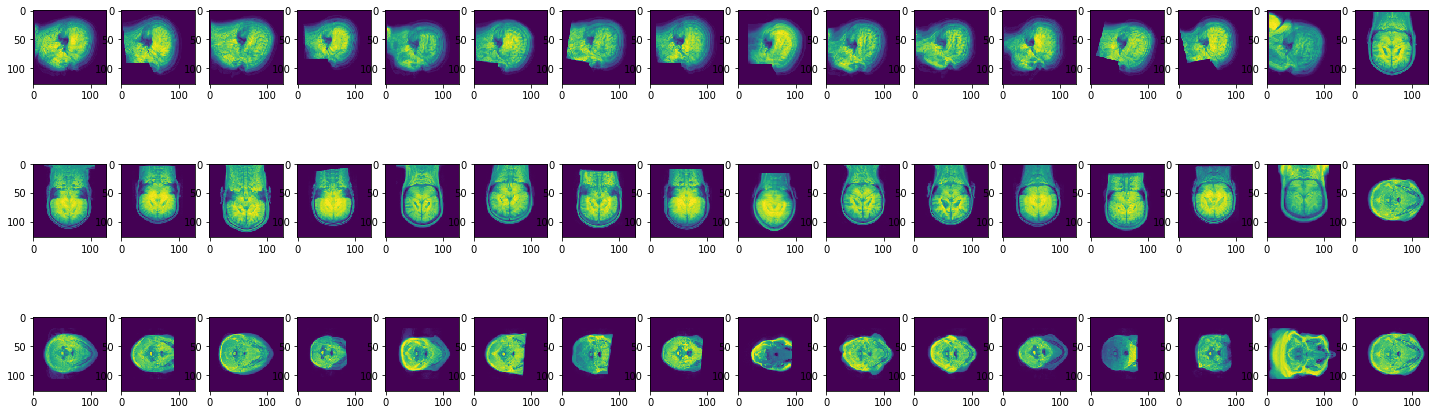

Predicted:  0 Actual:  1


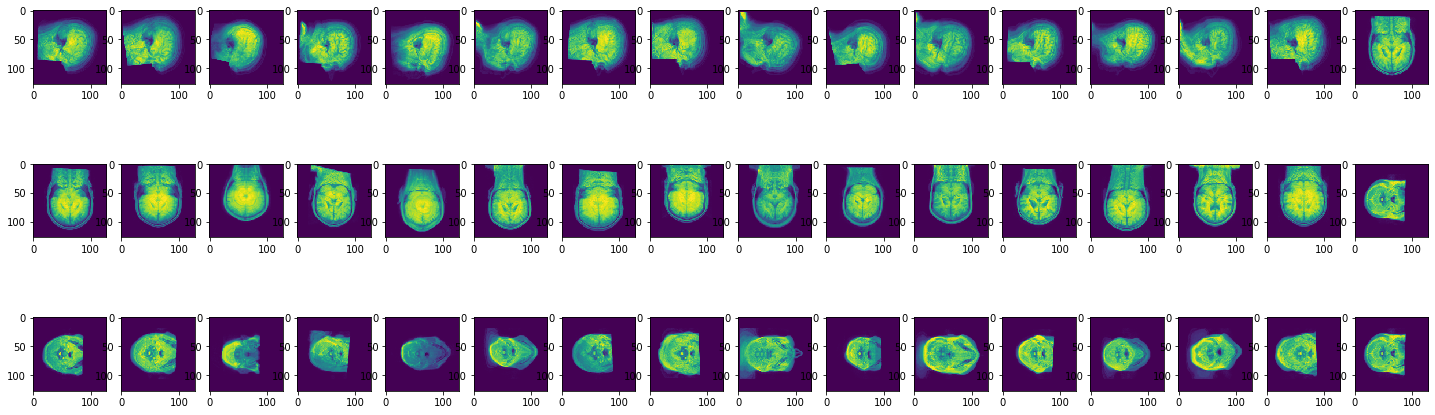

Predicted:  0 Actual:  1


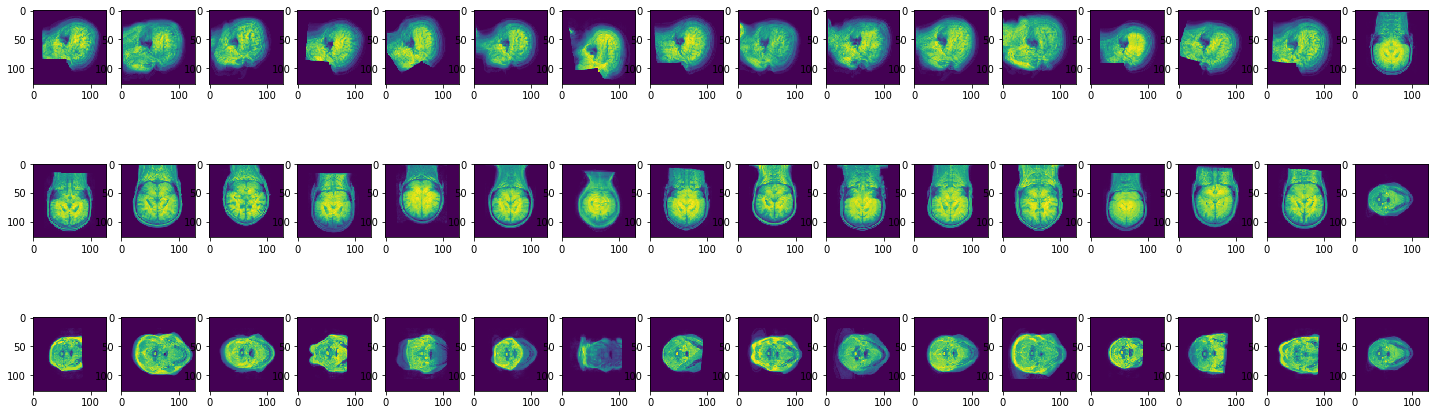

Predicted:  1 Actual:  0


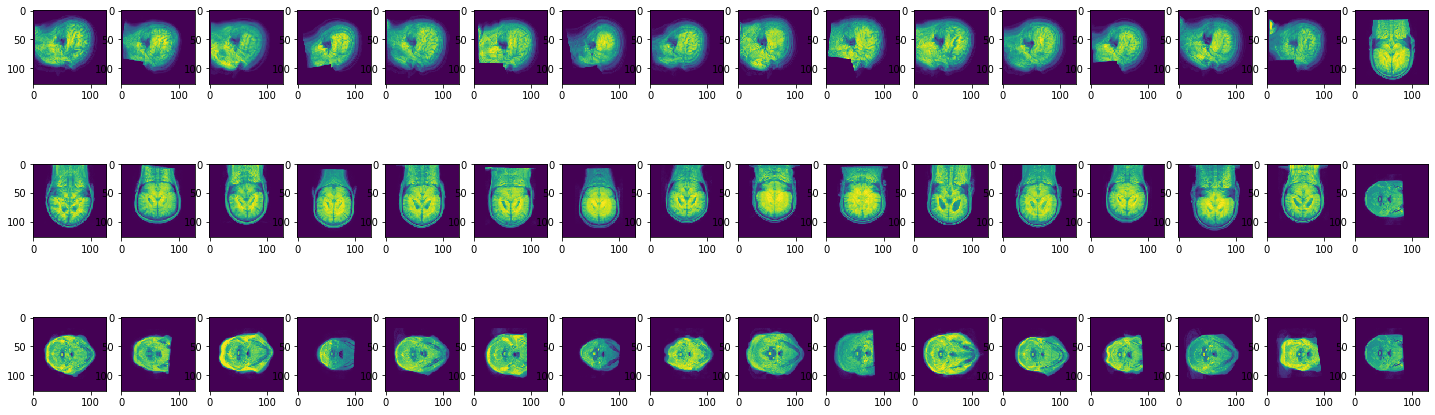

Predicted:  0 Actual:  1


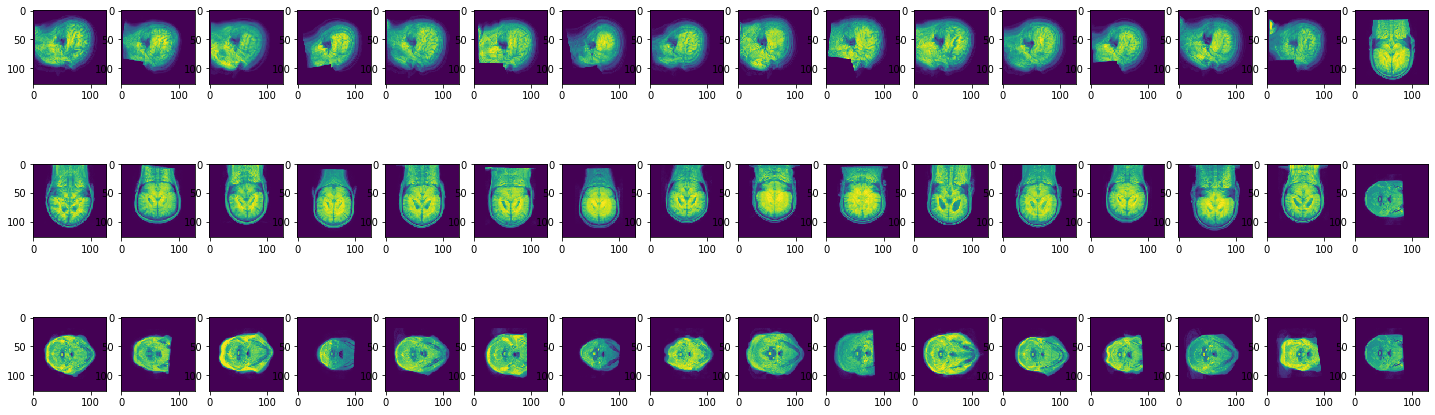

Predicted:  0 Actual:  1


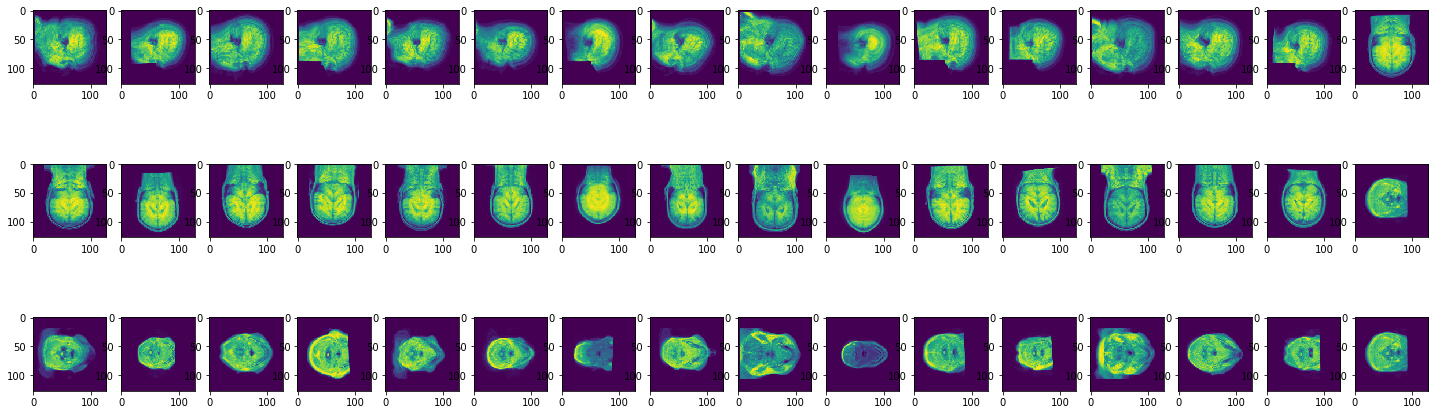

Predicted:  0 Actual:  1


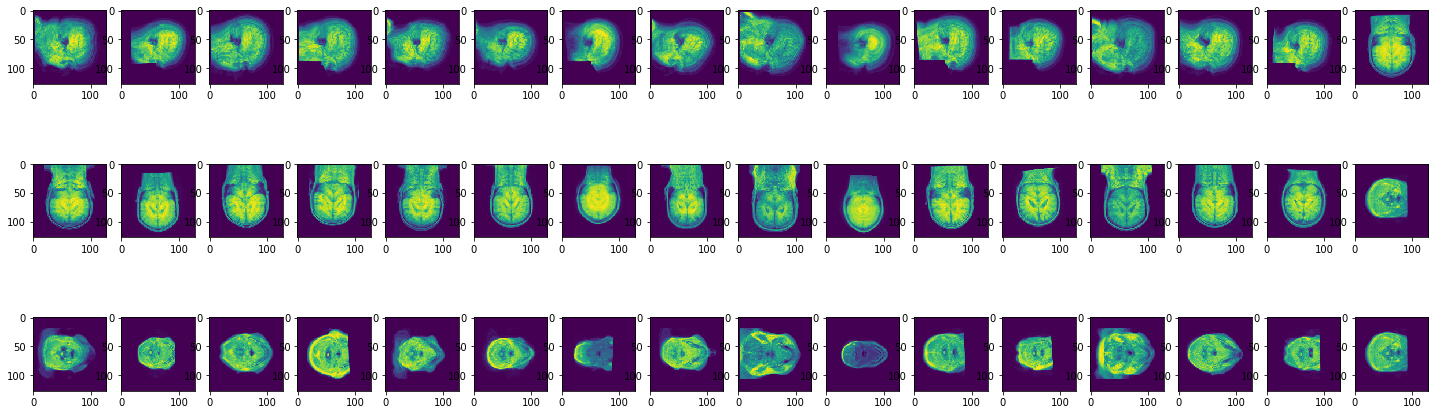

Predicted:  0 Actual:  1


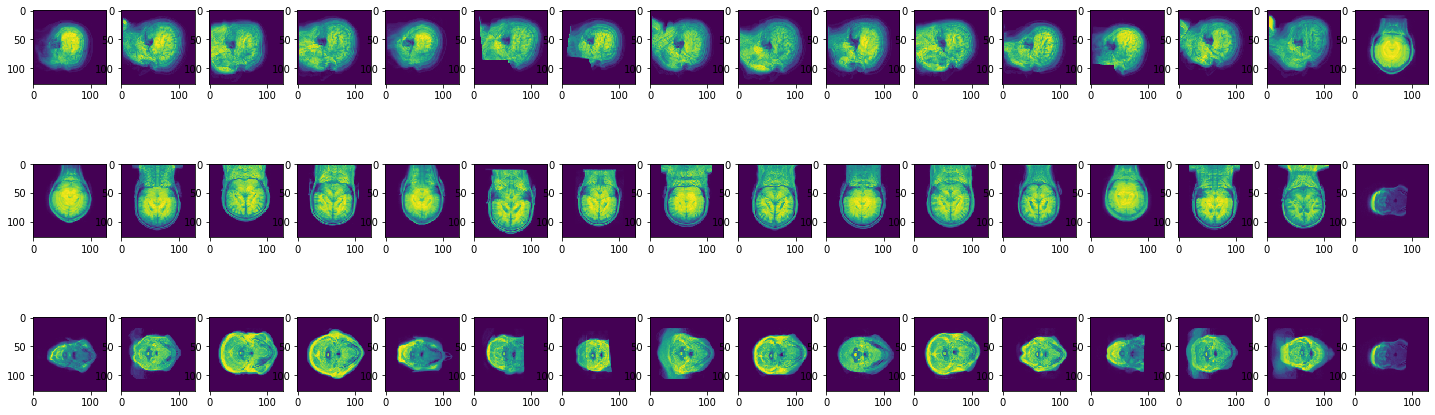

Predicted:  0 Actual:  1


KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
corr_pred_map = {}

for x, y in dataset_test.as_numpy_iterator():
    
    batch_predictions = (model.predict(x) > 0.5).astype(int)
    all_imgs = []
    for i in range(len(batch_predictions)):
        if batch_predictions.flatten()[i] != y.flatten()[i].astype(int):
            print("Predicted: ",batch_predictions.flatten()[i], "Actual: ", y.flatten()[i].astype(int))
            
            fig = plt.figure(figsize=(25, 8))
            rows, cols = 3, 16
            use = x['axial']
            for i in range(1, cols*rows + 1):
                if i/cols == 1:
                    use = x['coronal']
                if i/cols == 2:
                    use = x['sagittal']
                    
                fig.add_subplot(rows, cols, i)
                
                plt.imshow(use[(i-1)%cols,:,:, 0])


            plt.show()